# Solar Orbiter
This example demonstrates a ballistic model inspired by the solar orbiter mission.

In [1]:
# Pykep imports
from pykep.trajopt import mga_1dsm, launchers
from pykep.planet import jpl_lp
from pykep import epoch
from pykep.core import lambert_problem, propagate_lagrangian, fb_prop
from pykep import DAY2SEC, DAY2YEAR, AU, RAD2DEG, ic2par
from pykep.trajopt.gym._solar_orbiter import _solar_orbiter_udp

# Other imports
import numpy as np
from numpy.linalg import norm
from numpy import sign
from math import acos, asin, cos, exp, log, pi, sin
import matplotlib.pyplot as plt
from copy import deepcopy
import pygmo
import time

In [2]:
#%matplotlib notebook

In [3]:
# define search window
tmin = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 - 2*365)
tmax = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 + 2*365)

In [4]:
solar_orbiter = _solar_orbiter_udp([tmin, tmax])

In [5]:
# Include delta v, mass and sun distance constraints
prob = pygmo.unconstrain(pygmo.problem(solar_orbiter),method="weighted",weights=[1.0, 10.0, 100, 100])

In [6]:
# define problem and algorithm
pop = pygmo.population(prob=prob, size=50)
alg = pygmo.algorithm(pygmo.sade(memory=True,gen=1))

In [7]:
# run evolution
for i in range(3000):
    pop = alg.evolve(pop)
    print(i, pop.champion_f, solar_orbiter.fitness(pop.champion_x))

0 [21048.53347741] [1.3383478697826345, 18940.245640061752, 208.9, 0.17949489482970307, -0.19999999999999996]
1 [20220.93231652] [1.5202472880596616, 18130.412069232945, 208.9, -0.023912374581978868, -0.19999999999999996]
2 [20220.93231652] [1.5202472880596616, 18130.412069232945, 208.9, -0.023912374581978868, -0.19999999999999996]
3 [20166.68681725] [1.542642323382884, 18076.14417492384, 208.9, -0.35221380282731685, -0.19999999999999996]
4 [20166.68681725] [1.542642323382884, 18076.14417492384, 208.9, -0.35221380282731685, -0.19999999999999996]
5 [6869.98690581] [1.556159375059721, 4779.430746438371, 208.9, -0.4387248657415189, -0.19999999999999996]
6 [6869.98690581] [1.556159375059721, 4779.430746438371, 208.9, -0.4387248657415189, -0.19999999999999996]
7 [6869.98690581] [1.556159375059721, 4779.430746438371, 208.9, -0.4387248657415189, -0.19999999999999996]
8 [6869.98690581] [1.556159375059721, 4779.430746438371, 208.9, -0.4387248657415189, -0.19999999999999996]
9 [6869.98690581] [1

75 [6382.24698019] [1.444211398591384, 6380.802768787999, -4878.938340926382, -0.20319332506633792, -0.19999999999999996]
76 [6382.24698019] [1.444211398591384, 6380.802768787999, -4878.938340926382, -0.20319332506633792, -0.19999999999999996]
77 [6382.24698019] [1.444211398591384, 6380.802768787999, -4878.938340926382, -0.20319332506633792, -0.19999999999999996]
78 [6382.24698019] [1.444211398591384, 6380.802768787999, -4878.938340926382, -0.20319332506633792, -0.19999999999999996]
79 [6382.24698019] [1.444211398591384, 6380.802768787999, -4878.938340926382, -0.20319332506633792, -0.19999999999999996]
80 [6382.24698019] [1.444211398591384, 6380.802768787999, -4878.938340926382, -0.20319332506633792, -0.19999999999999996]
81 [5494.90012813] [1.4795566408660208, 5490.539105658965, -4487.620028215316, 0.028814658345045985, -0.19895534657180636]
82 [5494.90012813] [1.4795566408660208, 5490.539105658965, -4487.620028215316, 0.028814658345045985, -0.19895534657180636]
83 [5494.90012813] [1.

146 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]
147 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]
148 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]
149 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]
150 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]
151 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]
152 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]
153 [1327.02000419] [1.4808780349747173, 1325.5391261509776, -1500.933576210452, -0.22100678308694788, -0.19999999999999996]


212 [1206.41621628] [1.4394677725094658, 1204.9767485035927, -3511.9469411344876, -0.10965911319837901, -0.19999999999999996]
213 [1206.41621628] [1.4394677725094658, 1204.9767485035927, -3511.9469411344876, -0.10965911319837901, -0.19999999999999996]
214 [1206.41621628] [1.4394677725094658, 1204.9767485035927, -3511.9469411344876, -0.10965911319837901, -0.19999999999999996]
215 [1206.41621628] [1.4394677725094658, 1204.9767485035927, -3511.9469411344876, -0.10965911319837901, -0.19999999999999996]
216 [1206.41621628] [1.4394677725094658, 1204.9767485035927, -3511.9469411344876, -0.10965911319837901, -0.19999999999999996]
217 [1206.39819878] [1.4214502771174122, 1204.9767485035927, -3511.9469411344876, -0.2919351319774933, -0.19999999999999996]
218 [1164.00010054] [1.419462039899394, 1162.580638500457, -3511.9469411344876, -0.2860895556477937, -0.19999999999999996]
219 [1164.00010054] [1.419462039899394, 1162.580638500457, -3511.9469411344876, -0.2860895556477937, -0.19999999999999996]

282 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999999996]
283 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999999996]
284 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999999996]
285 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999999996]
286 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999999996]
287 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999999996]
288 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999999996]
289 [1079.77143525] [1.3989273904569988, 1078.3725078572004, -3767.9375748422676, -0.17424904826843646, -0.19999999999

353 [750.94053112] [1.4046275900980096, 749.5359035298734, -1903.82741388572, -0.27617591657810836, -0.19999999999999996]
354 [750.94053112] [1.4046275900980096, 749.5359035298734, -1903.82741388572, -0.27617591657810836, -0.19999999999999996]
355 [750.94053112] [1.4046275900980096, 749.5359035298734, -1903.82741388572, -0.27617591657810836, -0.19999999999999996]
356 [750.94053112] [1.4046275900980096, 749.5359035298734, -1903.82741388572, -0.27617591657810836, -0.19999999999999996]
357 [750.94053112] [1.4046275900980096, 749.5359035298734, -1903.82741388572, -0.27617591657810836, -0.19999999999999996]
358 [750.94053112] [1.4046275900980096, 749.5359035298734, -1903.82741388572, -0.27617591657810836, -0.19999999999999996]
359 [746.19317754] [1.4038108428991452, 744.7893666972759, -1903.82741388572, -0.2634841090684513, -0.19999999999999996]
360 [746.19312437] [1.4037576751416223, 744.7893666972759, -1903.82741388572, -0.26350585738334087, -0.19999999999999996]
361 [746.19312437] [1.403

427 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
428 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
429 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
430 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
431 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
432 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
433 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
434 [357.26208409] [1.3915080713083534, 355.8705760159655, -1903.82741388572, -0.19138551294772238, -0.19656644674321155]
435 [357.26208409] [1.39

495 [357.26208248] [1.3915064649763618, 355.8705760159655, -1903.82741388572, -0.19138569985332993, -0.19656644674321155]
496 [352.30187377] [1.3830553905710192, 350.9188183786291, -1903.82741388572, -0.22805598026666385, -0.19999999999999996]
497 [352.30187377] [1.3830553905710192, 350.9188183786291, -1903.82741388572, -0.22805598026666385, -0.19999999999999996]
498 [352.30187377] [1.3830553905710192, 350.9188183786291, -1903.82741388572, -0.22805598026666385, -0.19999999999999996]
499 [352.30187377] [1.3830553905710192, 350.9188183786291, -1903.82741388572, -0.22805598026666385, -0.19999999999999996]
500 [352.30187377] [1.3830553905710192, 350.9188183786291, -1903.82741388572, -0.22805598026666385, -0.19999999999999996]
501 [352.30187377] [1.3830553905710192, 350.9188183786291, -1903.82741388572, -0.22805598026666385, -0.19999999999999996]
502 [352.30187377] [1.3830553905710192, 350.9188183786291, -1903.82741388572, -0.22805598026666385, -0.19999999999999996]
503 [352.30187377] [1.38

569 [53.88228801] [1.404332110987656, 52.477955898963955, -1757.3018709690111, -0.2980697845115813, -0.19999999999999996]
570 [53.8743232] [1.3963673033661421, 52.477955898963955, -1757.3018709690111, -0.3037611063707143, -0.19999999999999996]
571 [53.8743232] [1.3963673033661421, 52.477955898963955, -1757.3018709690111, -0.3037611063707143, -0.19999999999999996]
572 [53.8743232] [1.3963673033661421, 52.477955898963955, -1757.3018709690111, -0.3037611063707143, -0.19999999999999996]
573 [53.8743232] [1.3963673033661421, 52.477955898963955, -1757.3018709690111, -0.3037611063707143, -0.19999999999999996]
574 [53.8743232] [1.3963673033661421, 52.477955898963955, -1757.3018709690111, -0.3037611063707143, -0.19999999999999996]
575 [53.8743232] [1.3963673033661421, 52.477955898963955, -1757.3018709690111, -0.3037611063707143, -0.19999999999999996]
576 [53.8743232] [1.3963673033661421, 52.477955898963955, -1757.3018709690111, -0.3037611063707143, -0.19999999999999996]
577 [53.8743232] [1.3963

641 [33.48518193] [1.4157786985210707, 32.069403230505486, -1709.4664678229897, -0.33845810500803664, -0.19999999999999996]
642 [33.48518193] [1.4157786985210707, 32.069403230505486, -1709.4664678229897, -0.33845810500803664, -0.19999999999999996]
643 [33.48518193] [1.4157786985210707, 32.069403230505486, -1709.4664678229897, -0.33845810500803664, -0.19999999999999996]
644 [33.48518193] [1.4157786985210707, 32.069403230505486, -1709.4664678229897, -0.33845810500803664, -0.19999999999999996]
645 [33.48518193] [1.4157786985210707, 32.069403230505486, -1709.4664678229897, -0.33845810500803664, -0.19999999999999996]
646 [33.48518191] [1.415778683390967, 32.069403230505486, -1709.4664678229897, -0.3384581154449591, -0.19999999999999996]
647 [33.48518191] [1.415778683390967, 32.069403230505486, -1709.4664678229897, -0.3384581154449591, -0.19999999999999996]
648 [33.48518191] [1.415778683390967, 32.069403230505486, -1709.4664678229897, -0.3384581154449591, -0.19999999999999996]
649 [33.485181

714 [17.07565048] [1.3837020572985346, 15.691948420195331, -1774.476686511848, -0.2591870508177937, -0.19999999999999996]
715 [17.07565048] [1.3837020572985346, 15.691948420195331, -1774.476686511848, -0.2591870508177937, -0.19999999999999996]
716 [17.07565048] [1.3837020572985346, 15.691948420195331, -1774.476686511848, -0.2591870508177937, -0.19999999999999996]
717 [17.07565048] [1.3837020572985346, 15.691948420195331, -1774.476686511848, -0.2591870508177937, -0.19999999999999996]
718 [17.07565048] [1.3837020572985346, 15.691948420195331, -1774.476686511848, -0.2591870508177937, -0.19999999999999996]
719 [17.07565042] [1.383702004174908, 15.691948420195331, -1774.476686511848, -0.2591870690182798, -0.19999999999999996]
720 [17.07565042] [1.383702004174908, 15.691948420195331, -1774.476686511848, -0.2591870690182798, -0.19999999999999996]
721 [15.39925587] [1.383618218295686, 14.015637652951227, -1774.476686511848, -0.2598343359242069, -0.19999999999999996]
722 [15.39925587] [1.383618

785 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
786 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
787 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
788 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
789 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
790 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
791 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
792 [3.82588916] [1.3887179571116857, 2.4371712003012362, -1817.2181912870278, -0.20748576972533794, -0.1951858130227071]
793 [3.82588916] [1.3887

857 [1.38866661] [1.3886666129293705, -4.372144354338161, -1817.2181912870278, -0.20764519132780473, -0.19516597197001406]
858 [1.38866661] [1.3886666129293705, -4.372144354338161, -1817.2181912870278, -0.20764519132780473, -0.19516597197001406]
859 [1.38866661] [1.3886666129293705, -4.372144354338161, -1817.2181912870278, -0.20764519132780473, -0.19516597197001406]
860 [1.38866661] [1.3886666129293705, -4.372144354338161, -1817.2181912870278, -0.20764519132780473, -0.19516597197001406]
861 [1.38866661] [1.3886666129293705, -4.372144354338161, -1817.2181912870278, -0.20764519132780473, -0.19516597197001406]
862 [1.38809263] [1.3880926287674227, -5.948008617368032, -1761.2800531191665, -0.22179143259269274, -0.19448619558071933]
863 [1.38809263] [1.3880926287674227, -5.948008617368032, -1761.2800531191665, -0.22179143259269274, -0.19448619558071933]
864 [1.38809263] [1.3880926287674227, -5.948008617368032, -1761.2800531191665, -0.22179143259269274, -0.19448619558071933]
865 [1.38809263]

927 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
928 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
929 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
930 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
931 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
932 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
933 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
934 [1.38782428] [1.387824283900038, -2.9151382713935163, -1784.8803413443818, -0.2167391272526904, -0.1948073414576459]
935 [1.38775203] [1.387752025396

995 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
996 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
997 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
998 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
999 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
1000 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
1001 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
1002 [1.38695793] [1.3869579279053523, -1.382155613433497, -1833.8318294520056, -0.21053054732673993, -0.19999999999999996]
1003 [1.38695

1065 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1066 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1067 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1068 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1069 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1070 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1071 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1072 [1.38595487] [1.3859548717434786, -1.3398609749274328, -1789.1127627226, -0.21496928075577953, -0.19999999999999996]
1073 [1.38595487] [1.385

1135 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1136 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1137 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1138 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1139 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1140 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1141 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1142 [1.3850908] [1.3850907966086201, -6.447124429231735, -1772.70597412945, -0.2208082135786552, -0.19999999999999996]
1143 [1.38499995] [1.3849999460308593, -

1203 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1204 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1205 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1206 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1207 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1208 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1209 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1210 [1.38436872] [1.3843687237115796, -2.789083675645088, -1768.796304580659, -0.22377317501377225, -0.19999999999999996]
1211 [1.38436872

1275 [1.38410974] [1.384109737992473, -1.159504912585362, -1744.8693178720714, -0.2239129751904282, -0.19999999999999996]
1276 [1.38410974] [1.384109737992473, -1.159504912585362, -1744.8693178720714, -0.2239129751904282, -0.19999999999999996]
1277 [1.38410974] [1.384109737992473, -1.159504912585362, -1744.8693178720714, -0.2239129751904282, -0.19999999999999996]
1278 [1.38410974] [1.384109737992473, -1.159504912585362, -1744.8693178720714, -0.2239129751904282, -0.19999999999999996]
1279 [1.38410974] [1.384109737992473, -1.159504912585362, -1744.8693178720714, -0.2239129751904282, -0.19999999999999996]
1280 [1.38410974] [1.384109737992473, -1.159504912585362, -1744.8693178720714, -0.2239129751904282, -0.19999999999999996]
1281 [1.38374854] [1.3837485371200973, -2.223607779030317, -1734.0672331071605, -0.22558207942235176, -0.19999999999999996]
1282 [1.38374854] [1.3837485371200973, -2.223607779030317, -1734.0672331071605, -0.22558207942235176, -0.19999999999999996]
1283 [1.38374854] [1

1346 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]
1347 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]
1348 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]
1349 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]
1350 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]
1351 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]
1352 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]
1353 [1.38338817] [1.3833881735533087, -0.4995029107267328, -1718.8458363668753, -0.22876994811572005, -0.19999999999999996]


1416 [1.38321547] [1.383215471684806, -0.04104260210078792, -1711.7032263444648, -0.22961697276521587, -0.19999999999999996]
1417 [1.38321547] [1.383215471684806, -0.04104260210078792, -1711.7032263444648, -0.22961697276521587, -0.19999999999999996]
1418 [1.38321547] [1.383215471684806, -0.04104260210078792, -1711.7032263444648, -0.22961697276521587, -0.19999999999999996]
1419 [1.38321547] [1.383215470045584, -0.04104260210078792, -1711.7032263444648, -0.2296169730940657, -0.19999999999999996]
1420 [1.38321547] [1.383215470045584, -0.04104260210078792, -1711.7032263444648, -0.2296169730940657, -0.19999999999999996]
1421 [1.38321547] [1.383215470045584, -0.04104260210078792, -1711.7032263444648, -0.2296169730940657, -0.19999999999999996]
1422 [1.38321547] [1.383215470045584, -0.04104260210078792, -1711.7032263444648, -0.2296169730940657, -0.19999999999999996]
1423 [1.38321547] [1.383215470045584, -0.04104260210078792, -1711.7032263444648, -0.2296169730940657, -0.19999999999999996]
1424 

1483 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1484 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1485 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1486 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1487 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1488 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1489 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1490 [1.38290672] [1.3829067165849234, -1.446227930342502, -1701.6217404917004, -0.23083040207980554, -0.19999999999999996]
1491 [1.

1551 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]
1552 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]
1553 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]
1554 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]
1555 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]
1556 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]
1557 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]
1558 [1.38253352] [1.3825335182497616, -3.7457852736151835, -1684.7847977111433, -0.23276663678752507, -0.19999999999999996]


1623 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1624 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1625 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1626 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1627 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1628 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1629 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1630 [1.38243017] [1.3824301723338963, -2.0515888837335297, -1680.2538174773274, -0.2335419430049035, -0.19999999999999996]
1631 [1.

1698 [1.38223745] [1.3822374533383677, -3.359372863093995, -1668.621996596289, -0.23478398493754438, -0.19999999999999996]
1699 [1.38219088] [1.3821908757810462, -1.4885370335541666, -1671.9790562284718, -0.23513443150222013, -0.19999999999999996]
1700 [1.38219088] [1.3821908757810462, -1.4885370335541666, -1671.9790562284718, -0.23513443150222013, -0.19999999999999996]
1701 [1.38219088] [1.3821908757810462, -1.4885370335541666, -1671.9790562284718, -0.23513443150222013, -0.19999999999999996]
1702 [1.38219088] [1.3821908757810462, -1.4885370335541666, -1671.9790562284718, -0.23513443150222013, -0.19999999999999996]
1703 [1.38212912] [1.3821291221305865, -0.4130540001551708, -1676.5423187430047, -0.23554501291709395, -0.19999999999999996]
1704 [1.38212912] [1.3821291221305865, -0.4130540001551708, -1676.5423187430047, -0.23554501291709395, -0.19999999999999996]
1705 [1.38212912] [1.3821291221305865, -0.4130540001551708, -1676.5423187430047, -0.23554501291709395, -0.19999999999999996]
17

1771 [1.38211261] [1.382112612481603, -3.6277923992938668, -1669.2315970921932, -0.2355810289734378, -0.19999999999999996]
1772 [1.38211261] [1.382112612481603, -3.6277923992938668, -1669.2315970921932, -0.2355810289734378, -0.19999999999999996]
1773 [1.38211261] [1.382112612481603, -3.6277923992938668, -1669.2315970921932, -0.2355810289734378, -0.19999999999999996]
1774 [1.3821126] [1.3821126026580606, -3.6277923992938668, -1669.2315970921932, -0.2355955937068006, -0.19999999999999996]
1775 [1.3821126] [1.3821126026580606, -3.6277923992938668, -1669.2315970921932, -0.2355955937068006, -0.19999999999999996]
1776 [1.3821126] [1.3821126026580606, -3.6277923992938668, -1669.2315970921932, -0.2355955937068006, -0.19999999999999996]
1777 [1.3821126] [1.3821126026580606, -3.6277923992938668, -1669.2315970921932, -0.2355955937068006, -0.19999999999999996]
1778 [1.3821126] [1.3821126026580606, -3.6277923992938668, -1669.2315970921932, -0.2355955937068006, -0.19999999999999996]
1779 [1.3821126]

1843 [1.3816724] [1.3816724044072806, -0.012804654514184222, -1661.2353708221287, -0.23944589997709897, -0.19999999999999996]
1844 [1.3816724] [1.3816724044072806, -0.012804654514184222, -1661.2353708221287, -0.23944589997709897, -0.19999999999999996]
1845 [1.38158146] [1.381581461955686, -1.3279036035910394, -1661.2353708221287, -0.2404458838382194, -0.19999999999999996]
1846 [1.38158146] [1.381581461955686, -1.3279036035910394, -1661.2353708221287, -0.2404458838382194, -0.19999999999999996]
1847 [1.38158146] [1.381581461955686, -1.3279036035910394, -1661.2353708221287, -0.2404458838382194, -0.19999999999999996]
1848 [1.38158146] [1.381581461955686, -1.3279036035910394, -1661.2353708221287, -0.2404458838382194, -0.19999999999999996]
1849 [1.38158146] [1.381581461955686, -1.3279036035910394, -1661.2353708221287, -0.2404458838382194, -0.19999999999999996]
1850 [1.38158146] [1.381581461955686, -1.3279036035910394, -1661.2353708221287, -0.2404458838382194, -0.19999999999999996]
1851 [1.38

1912 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1913 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1914 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1915 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1916 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1917 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1918 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1919 [1.3814563] [1.381456303577782, -0.7123455161163292, -1653.0900262221471, -0.2431878308672879, -0.19999999999999996]
1920 [1.3814563] [1.3814

1980 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1981 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1982 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1983 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1984 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1985 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1986 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1987 [1.38136479] [1.3813647921152166, -0.4771066659441203, -1623.646549046929, -0.24472154808837987, -0.19999999999999996]
1988 [1.

2055 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2056 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2057 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2058 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2059 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2060 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2061 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2062 [1.38136478] [1.3813647781918315, -0.4771066659441203, -1623.646549046929, -0.2446414743887736, -0.19999999999999996]
2063 [1.38136478

2124 [1.38134556] [1.3813455645795771, -0.015041333349472552, -1617.8735258767924, -0.24514527961161225, -0.19999999999999996]
2125 [1.38134556] [1.3813455645795771, -0.015041333349472552, -1617.8735258767924, -0.24514527961161225, -0.19999999999999996]
2126 [1.38134556] [1.3813455645795771, -0.015041333349472552, -1617.8735258767924, -0.24514527961161225, -0.19999999999999996]
2127 [1.38134556] [1.3813455645795771, -0.015041333349472552, -1617.8735258767924, -0.24514527961161225, -0.19999999999999996]
2128 [1.38134556] [1.3813455645795771, -0.015041333349472552, -1617.8735258767924, -0.24514527961161225, -0.19999999999999996]
2129 [1.38134556] [1.3813455645795771, -0.015041333349472552, -1617.8735258767924, -0.24514527961161225, -0.19999999999999996]
2130 [1.38132777] [1.381327765415651, -0.10275715739408042, -1612.0171844808062, -0.2453797063627332, -0.19999999999999996]
2131 [1.38132777] [1.381327765415651, -0.10275715739408042, -1612.0171844808062, -0.2453797063627332, -0.199999999

2193 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2194 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2195 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2196 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2197 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2198 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2199 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2200 [1.38132203] [1.3813220278782101, -0.31401410491253046, -1609.999979365216, -0.2453906120935232, -0.19999999999999996]
2201 [1.

2265 [1.38124598] [1.381245980366024, -0.9395570943779603, -1582.1382663023323, -0.24519106305452099, -0.19999999999999996]
2266 [1.38124598] [1.381245980366024, -0.9395570943779603, -1582.1382663023323, -0.24519106305452099, -0.19999999999999996]
2267 [1.38124598] [1.381245980366024, -0.9395570943779603, -1582.1382663023323, -0.24519106305452099, -0.19999999999999996]
2268 [1.38124598] [1.381245980366024, -0.9395570943779603, -1582.1382663023323, -0.24519106305452099, -0.19999999999999996]
2269 [1.38124598] [1.381245980366024, -0.9395570943779603, -1582.1382663023323, -0.24519106305452099, -0.19999999999999996]
2270 [1.38123642] [1.3812364200846685, -1.2903491309143647, -1582.1382663023323, -0.245879050424047, -0.19999999999999996]
2271 [1.38123642] [1.381236415000566, -1.2903491309143647, -1582.1382663023323, -0.2459413621938774, -0.19999999999999996]
2272 [1.38123642] [1.381236415000566, -1.2903491309143647, -1582.1382663023323, -0.2459413621938774, -0.19999999999999996]
2273 [1.381

2340 [1.3810913] [1.3810913010859232, -1.1050557138823933, -1535.9626891956298, -0.24687391730455632, -0.19999999999999996]
2341 [1.38108859] [1.381088587337552, -0.760264074539009, -1535.1122897981388, -0.24688042606690663, -0.19999999999999996]
2342 [1.38107421] [1.381074213073968, -0.20529421395895042, -1530.6908809641175, -0.24695581514990916, -0.19999999999999996]
2343 [1.38107421] [1.381074213073968, -0.20529421395895042, -1530.6908809641175, -0.24695581514990916, -0.19999999999999996]
2344 [1.38107421] [1.381074213073968, -0.20529421395895042, -1530.6908809641175, -0.24695581514990916, -0.19999999999999996]
2345 [1.38107421] [1.381074213073968, -0.20529421395895042, -1530.6908809641175, -0.24695581514990916, -0.19999999999999996]
2346 [1.38107421] [1.381074213073968, -0.20529421395895042, -1530.6908809641175, -0.24695581514990916, -0.19999999999999996]
2347 [1.38105421] [1.3810542119664313, -1.0338231601990628, -1521.3413979619286, -0.24652316390254836, -0.19999999999999996]
234

2413 [1.38100145] [1.3810014469374106, -0.23507516272093198, -1507.4309266925684, -0.24909800125558867, -0.19999999999999996]
2414 [1.38100145] [1.3810014469374106, -0.23507516272093198, -1507.4309266925684, -0.24909800125558867, -0.19999999999999996]
2415 [1.38100145] [1.3810014469374106, -0.23507516272093198, -1507.4309266925684, -0.24909800125558867, -0.19999999999999996]
2416 [1.38095275] [1.380952746852617, -0.5297234682529961, -1487.2106080677058, -0.24687018320299436, -0.19999999999999996]
2417 [1.38095275] [1.380952746852617, -0.5297234682529961, -1487.2106080677058, -0.24687018320299436, -0.19999999999999996]
2418 [1.38095275] [1.380952746852617, -0.5297234682529961, -1487.2106080677058, -0.24687018320299436, -0.19999999999999996]
2419 [1.38095275] [1.380952746852617, -0.5297234682529961, -1487.2106080677058, -0.24687018320299436, -0.19999999999999996]
2420 [1.38095275] [1.380952746852617, -0.5297234682529961, -1487.2106080677058, -0.24687018320299436, -0.19999999999999996]
24

2484 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2485 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2486 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2487 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2488 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2489 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2490 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2491 [1.38092611] [1.3809261105367026, -1.2782052515985924, -1487.3788579814748, -0.2487142523136774, -0.19999999999999996]
2492 [1.

2553 [1.38092441] [1.3809244102260045, -0.8696228994185731, -1487.1946112715834, -0.24884501700881057, -0.19999999999999996]
2554 [1.38092387] [1.3809238743225083, -2.0895145684180534, -1486.746728333764, -0.24865916952025746, -0.19999999999999996]
2555 [1.38092387] [1.3809238743225083, -2.0895145684180534, -1486.746728333764, -0.24865916952025746, -0.19999999999999996]
2556 [1.38092387] [1.3809238743225083, -2.0895145684180534, -1486.746728333764, -0.24865916952025746, -0.19999999999999996]
2557 [1.38092387] [1.3809238743225083, -2.0895145684180534, -1486.746728333764, -0.24865916952025746, -0.19999999999999996]
2558 [1.38092387] [1.3809238743225083, -2.0895145684180534, -1486.746728333764, -0.24865916952025746, -0.19999999999999996]
2559 [1.38092387] [1.3809238743225083, -2.0895145684180534, -1486.746728333764, -0.24865916952025746, -0.19999999999999996]
2560 [1.38092387] [1.3809238743225083, -2.0895145684180534, -1486.746728333764, -0.24865916952025746, -0.19999999999999996]
2561 [1

2621 [1.38091802] [1.3809180159442522, -0.081276317292577, -1486.058725170495, -0.24859003731396911, -0.19999999999999996]
2622 [1.38091802] [1.3809180159442522, -0.081276317292577, -1486.058725170495, -0.24859003731396911, -0.19999999999999996]
2623 [1.38091801] [1.3809180131283478, -0.081276317292577, -1486.058725170495, -0.24861949769016356, -0.19999999999999996]
2624 [1.38091801] [1.3809180131283478, -0.081276317292577, -1486.058725170495, -0.24861949769016356, -0.19999999999999996]
2625 [1.38091801] [1.3809180131283478, -0.081276317292577, -1486.058725170495, -0.24861949769016356, -0.19999999999999996]
2626 [1.38091801] [1.3809180131283478, -0.081276317292577, -1486.058725170495, -0.24861949769016356, -0.19999999999999996]
2627 [1.38091801] [1.3809180131283478, -0.081276317292577, -1486.058725170495, -0.24861949769016356, -0.19999999999999996]
2628 [1.38091801] [1.3809180130657572, -0.081276317292577, -1486.058725170495, -0.2486222195619937, -0.19999999999999996]
2629 [1.38091801]

2690 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]
2691 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]
2692 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]
2693 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]
2694 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]
2695 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]
2696 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]
2697 [1.38091662] [1.3809166170183054, -0.23776115845612367, -1486.1641332265517, -0.2488961113250272, -0.19999999999999996]


2757 [1.38091545] [1.3809154542764757, -0.060488922909826215, -1486.0782702789852, -0.24880915353749844, -0.19999999999999996]
2758 [1.38091545] [1.3809154542764757, -0.060488922909826215, -1486.0782702789852, -0.24880915353749844, -0.19999999999999996]
2759 [1.38091545] [1.3809154542764757, -0.060488922909826215, -1486.0782702789852, -0.24880915353749844, -0.19999999999999996]
2760 [1.38091545] [1.3809154542764757, -0.060488922909826215, -1486.0782702789852, -0.24880915353749844, -0.19999999999999996]
2761 [1.38091545] [1.3809154542764757, -0.060488922909826215, -1486.0782702789852, -0.24880915353749844, -0.19999999999999996]
2762 [1.38091432] [1.3809143164813142, -0.3556630847378983, -1486.0043154562559, -0.248702051640726, -0.19999999999999996]
2763 [1.38091432] [1.3809143164813142, -0.3556630847378983, -1486.0043154562559, -0.248702051640726, -0.19999999999999996]
2764 [1.38091432] [1.3809143164813142, -0.3556630847378983, -1486.0043154562559, -0.248702051640726, -0.199999999999999

2824 [1.38091383] [1.380913828265101, -0.005795293420305825, -1486.0033816128089, -0.2488075329155519, -0.19999999999999996]
2825 [1.38091383] [1.380913828265101, -0.005795293420305825, -1486.0033816128089, -0.2488075329155519, -0.19999999999999996]
2826 [1.38091383] [1.3809138282597624, -0.005795293420305825, -1486.0033816128089, -0.24881094124831216, -0.19999999999999996]
2827 [1.38091383] [1.3809138282597624, -0.005795293420305825, -1486.0033816128089, -0.24881094124831216, -0.19999999999999996]
2828 [1.38091383] [1.3809138282597624, -0.005795293420305825, -1486.0033816128089, -0.24881094124831216, -0.19999999999999996]
2829 [1.38091383] [1.3809138282597624, -0.005795293420305825, -1486.0033816128089, -0.24881094124831216, -0.19999999999999996]
2830 [1.38091383] [1.3809138282597624, -0.005795293420305825, -1486.0033816128089, -0.24881094124831216, -0.19999999999999996]
2831 [1.38091383] [1.3809138282597624, -0.005795293420305825, -1486.0033816128089, -0.24881094124831216, -0.1999999

2890 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2891 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2892 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2893 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2894 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2895 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2896 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2897 [1.38091379] [1.380913787548156, -0.06799293152289465, -1486.003866326939, -0.24882484212447809, -0.19999999999999996]
2898 [1.

2963 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999999996]
2964 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999999996]
2965 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999999996]
2966 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999999996]
2967 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999999996]
2968 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999999996]
2969 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999999996]
2970 [1.38091371] [1.3809137099690822, -0.00637711158105958, -1486.0225889359328, -0.24881996355912672, -0.19999999999

In [8]:
pop.champion_x

array([ 7.82318072e+03,  2.63232360e+02,  4.16695286e+02,  1.46415239e+02,
        1.58048743e+02, -3.28360872e+00,  1.05783212e+00])

In [9]:
solar_orbiter.fitness(pop.champion_x)

[1.3809136708657341,
 -0.0022936973791729542,
 -1486.0173161847313,
 -0.24882392777376516,
 -0.19999999999999996]

In [10]:
# start date
epoch(pop.champion_x[0])

2021-Jun-02 04:20:14.410984

In [11]:
# Inspect best result
solar_orbiter.pretty(pop.champion_x)

Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['earth', 'venus', 'venus', 'earth', 'venus']
Departure:  earth
	Epoch:  7823.180722349349  [mjd2000]
	Spacecraft velocity:  (23252.99438206375, -15596.404544370995, -1633.4398304663512) [m/s]
	Launch velocity:  [-4524.599901111698, -6071.07272488379, -1633.903354871923] [m/s]
Fly-by:  venus
	Epoch:  8086.413082290184  [mjd2000]
	DV:  9.922987326231123 [m/s]
Fly-by:  venus
	Epoch:  8503.108368097848  [mjd2000]
	DV:  0.0671021560783629 [m/s]
Fly-by:  earth
	Epoch:  8649.523606669314  [mjd2000]
	DV:  0.007616820311341144 [m/s]
Final Fly-by:  venus
	Epoch:  8807.572349515181  [mjd2000]
	Spacecraft velocity:  (29603.85750981922, -20543.81429141947, 45.50886195824546) [m/s]
	Beta:  -3.283608716308165
	r_p:  1.0578321216126916
Resulting Solar orbit:
Perihelion:  0.5288239277737652  AU
Aphelion:  0.9487785166516366  AU
Inclination:  10.87947478747576  degrees
Time of flights:  [263.23235994 416.69528581 146.41523857 158.04874285] [days

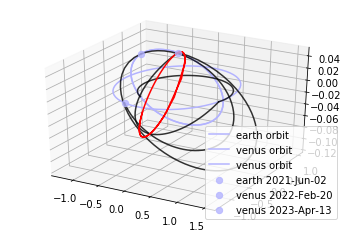

In [12]:
# Plot best result
solar_orbiter.plot(pop.champion_x)

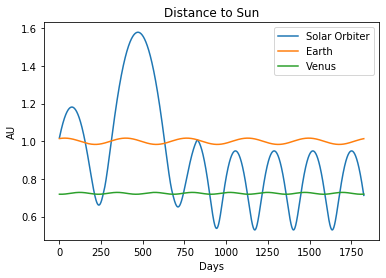

In [13]:
# Plot solar distance in AE
timeframe = range(1,5*365)
earth = jpl_lp("earth")
venus = jpl_lp("venus")

distances = []
edistances = []
vdistances = []

for i in timeframe:
    epoch = pop.champion_x[0]+i
    pos, vel = solar_orbiter.eph(pop.champion_x, epoch)
    epos, evel = earth.eph(epoch)
    vpos, vvel = venus.eph(epoch)
    distances.append(norm(pos) / AU)
    edistances.append(norm(epos) / AU)
    vdistances.append(norm(vpos) / AU)

fig, ax = plt.subplots()
ax.plot(list(timeframe), distances, label="Solar Orbiter")
ax.plot(list(timeframe), edistances, label="Earth")
ax.plot(list(timeframe), vdistances, label="Venus")
ax.set_xlabel("Days")
ax.set_ylabel("AU")
ax.set_title("Distance to Sun")
ax.legend()

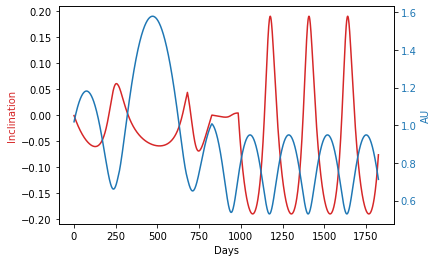

In [14]:
# Plot inclination and distance
inclinations = []
for i in timeframe:
    epoch = pop.champion_x[0]+i
    pos, _ = solar_orbiter.eph(pop.champion_x, epoch)
    inclination = sign(pos[2])*acos(norm(pos[:2]) / norm(pos))
    inclinations.append(inclination)

color = 'tab:red'
fig2, ax2 = plt.subplots()
ax2.plot(list(timeframe), inclinations, color=color)
ax2.set_ylabel("Inclination", color=color)
ax2.set_xlabel("Days")
ax.set_title("Distance and Inclination")

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('AU', color=color)
ax3.plot(list(timeframe), distances, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()